In [1]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import math
import pylab
import scipy.stats as stats
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel

In [2]:
ny_data = pd.read_csv('ny_data++_v4.csv', low_memory=False)
sf_data = pd.read_csv('sf++_clean_v4.csv', low_memory=False)

In [266]:
## Explore Data

#data.head()
# print(sf_data.shape)
# print(sf_data.columns)
# print(ny_data.columns)

print(ny_data.shape)
print(sf_data.shape)

(37384, 251)
(6311, 86)


# Run SVR

In [222]:
def get_common_columns(ny_data, sf_data):
    common_columns = set(ny_data.columns).intersection(set(sf_data.columns))
    # narrow down to same columns
    ny_data_1 = pd.DataFrame()
    sf_data_1 = pd.DataFrame()
    for item in common_columns:
        ny_data_1[item] = ny_data[item]
        sf_data_1[item] = sf_data[item]
    return ny_data_1, sf_data_1

In [3]:
def make_common_columns(ny_data, sf_data):
    ny_cols = list(ny_data.columns)
    sf_cols = list(sf_data.columns)
    for item in ny_cols:
        if item not in sf_cols:
            sf_data[item] = 0
    
    for item in sf_cols:
        if item not in ny_cols:
            ny_data[item] = 0
    
    return ny_data, sf_data

In [4]:
ny_data1, sf_data1 = make_common_columns(ny_data, sf_data)

In [5]:
print(sf_data1.shape)
print(ny_data1.shape)

(6293, 73)
(36760, 73)


In [228]:
print(sf_data1.columns)

Index(['number_of_reviews', 'Bungalow', 'Shared room', 'beds',
       'Entire home/apt', 'Earth house', 'Townhouse', 'Bed and breakfast',
       'sentiment_score', '30-39', 'Aparthotel', '95-100', 'guests_included',
       'commute_time_mins', 'accommodates', 'security_deposit',
       'host_identity_verified', 'Resort', 'Castle', 'hotel_count',
       'Condominium', 'Cottage', '40-49', 'cleaning_fee', 'Hostel',
       'Tiny house', 'Serviced apartment', 'Private room',
       'restaurant_density', 'Dome house', 'Loft', 'price', 'Guesthouse',
       'House', 'host_is_superhost', 'Hotel', 'Villa', '70-79', '20-29', 'id',
       'host_has_profile_pic', 'Other', 'Airbed', 'Guest suite', 'Futon',
       'Cabin', 'bathrooms', '90-94', 'Apartment', 'Hotel room',
       'Boutique hotel', 'poverty_percent', 'Couch', 'Real Bed',
       'dist_downtown', '50-59', 'bedrooms', '60-69', '80-84', 'host_since',
       'Pull-out Sofa', '85-89'],
      dtype='object')


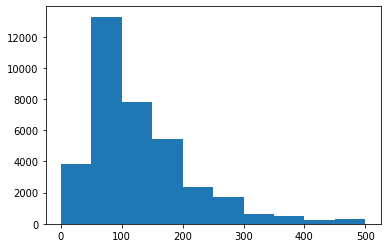

In [229]:
#plot price distribution
price = ny_data['price']
ranges = (0,500)
plt.hist(price, bins = 10, range = ranges)
plt.show()

#log of price

In [ ]:
#X_train.skew(axis = 0) #skew of price = 24

In [6]:
#drop id
#ny_data1 = ny_data.drop('id', axis = 1)
ny_data1.drop('id', axis = 1, inplace = True)
#drop id
sf_data1.drop('id', axis = 1, inplace = True)

In [7]:
print(sf_data1.columns)

Index(['host_since', 'host_is_superhost', 'host_has_profile_pic',
       'host_identity_verified', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'number_of_reviews', 'commute_time_mins', 'sentiment_score',
       'poverty_percent', 'restaurant_density', 'hotel_count', 'dist_downtown',
       'Aparthotel', 'Apartment', 'Bed and breakfast', 'Boutique hotel',
       'Bungalow', 'Cabin', 'Castle', 'Condominium', 'Cottage', 'Dome house',
       'Earth house', 'Guest suite', 'Guesthouse', 'Hostel', 'Hotel', 'House',
       'In-law', 'Loft', 'Other', 'Resort', 'Serviced apartment', 'Tiny house',
       'Townhouse', 'Villa', 'Entire home/apt', 'Hotel room', 'Private room',
       'Shared room', 'Airbed', 'Couch', 'Futon', 'Pull-out Sofa', 'Real Bed',
       '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-84', '85-89',
       '90-94', '95-100', 'Barn', 'Boat', 'Camper/RV',
       'Casa particular (Cuba)',

In [8]:
# Get SF Data
SF_X = sf_data1.copy()
SF_y = np.log(SF_X['price'])
SF_X = sf_data1.drop('price', axis = 1)

In [9]:
SF_X

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,Barn,Boat,Camper/RV,Casa particular (Cuba),Cave,Farm stay,Houseboat,Island,Nature lodge,Tent
0,11.353425,1,1,1,3,1.0,1,2,100,100,...,0,0,0,0,0,0,0,0,0,0
1,10.473973,1,1,1,2,4.0,1,1,200,50,...,0,0,0,0,0,0,0,0,0,0
2,10.473973,1,1,1,2,4.0,1,1,200,50,...,0,0,0,0,0,0,0,0,0,0
3,10.432877,0,1,1,4,1.5,2,2,0,225,...,0,0,0,0,0,0,0,0,0,0
4,10.227397,0,1,1,3,1.0,3,3,2500,208,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6288,0.230137,0,1,0,2,1.0,0,1,500,75,...,0,0,0,0,0,0,0,0,0,0
6289,1.443836,0,1,1,4,1.0,1,2,200,80,...,0,0,0,0,0,0,0,0,0,0
6290,2.605479,0,1,1,2,1.0,1,1,0,40,...,0,0,0,0,0,0,0,0,0,0
6291,0.290411,0,1,0,2,1.0,1,1,0,30,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# NY Data
X_train = ny_data1.copy()

In [11]:
#Get Y. Log transformation.
y_train = np.log(X_train['price'])
# y_valid = np.log(X_valid['price'])
# y_test = np.log(X_test['price'])

# y_train = X_train['price']
# y_valid = X_valid['price']
# y_test = X_test['price']

In [12]:
X_train.drop('price', axis = 1, inplace = True)
# X_valid.drop('price', axis = 1, inplace = True)
# X_test.drop('price', axis = 1, inplace = True)
# ny_data1.drop('price', axis = 1, inplace = True)

In [33]:
#normalize data
# X_train, X_valid, X_test = normalization_train_and_vali(X_train, X_valid, X_test)

In [13]:
X_train.head()

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,In-law
0,11.000000,0,1,1,3,1.0,1,4,500,0,...,0,0,0,0,0,0,0,1,0,0
1,10.260274,0,1,0,3,1.0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,10.101370,0,1,1,2,1.0,1,1,500,90,...,0,0,0,0,0,0,1,0,0,0
3,9.975342,1,1,1,8,2.0,4,4,1000,140,...,0,0,0,0,0,0,0,0,1,0
4,9.915068,1,1,1,2,1.0,1,1,0,47,...,0,0,0,0,0,0,0,0,1,0


In [16]:
#normalize NY data
X_train = normalize_sf(X_train, X_train)

In [17]:
#normalize SF data
SF_X = normalize_sf(ny_data1.drop('price', axis = 1), SF_X)

In [18]:
X_train.head()

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,In-law
0,2.685652,-0.554306,0.04305,0.992034,0.046877,-0.330420,-0.241418,2.098492,0.811508,-0.989199,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,1.917976,-1.263492,0.0
1,2.372134,-0.554306,0.04305,-1.008030,0.046877,-0.330420,-0.241418,-1.367526,-0.435194,-0.989199,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,1.917976,-1.263492,0.0
2,2.304786,-0.554306,0.04305,0.992034,-0.478009,-0.330420,-0.241418,-0.501022,0.811508,0.682199,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,3.526425,-0.521383,-1.263492,0.0
3,2.251372,1.804059,0.04305,0.992034,2.671305,2.060806,3.776028,2.098492,2.058209,1.610753,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,0.791457,0.0
4,2.225826,1.804059,0.04305,0.992034,-0.478009,-0.330420,-0.241418,-0.501022,-0.435194,-0.116358,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,0.791457,0.0


In [19]:
SF_X.head()

,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,...,30-39,40-49,50-59,60-69,70-79,80-84,85-89,90-94,95-100,In-law
0,2.835443,1.804059,0.04305,0.992034,0.046877,-0.330420,-0.241418,0.365483,-0.185853,0.867909,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,-1.263492,0.0
1,2.462706,1.804059,0.04305,0.992034,-0.478009,6.843258,-0.241418,-0.501022,0.063487,-0.060645,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,-1.263492,0.0
2,2.462706,1.804059,0.04305,0.992034,-0.478009,6.843258,-0.241418,-0.501022,0.063487,-0.060645,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,-1.263492,0.0
3,2.445288,-0.554306,0.04305,0.992034,0.571763,0.865193,1.097730,0.365483,-0.435194,3.189296,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,-1.263492,0.0
4,2.358200,-0.554306,0.04305,0.992034,0.046877,-0.330420,2.436879,1.231987,5.798314,2.873587,...,-0.013801,-0.053521,-0.036534,-0.111074,-0.132794,-0.253947,-0.283573,-0.521383,-1.263492,0.0


In [261]:
y_train.head()

0    4.488636
1    4.248495
2    4.700480
3    5.298317
4    4.653960
Name: price, dtype: float64

In [10]:
#normalize data
from sklearn. preprocessing import StandardScaler

#for test data- use the means and standard deviations saved from training data, rather than computing them from test data
def normalization_train_and_vali(train_X, valid_X, test_X):
    scaler = StandardScaler()
    scaler.fit(train_X)
    X_train = scaler.transform(train_X)
    X_valid = scaler.transform(valid_X)
    X_test = scaler.transform(test_X)
    
    #convert array to dataframe
    X_train = pd.DataFrame(X_train, columns = train_X.columns)
    X_valid = pd.DataFrame(X_valid, columns = train_X.columns)
    X_test = pd.DataFrame(X_test, columns = train_X.columns)
    
    return X_train, X_valid, X_test

In [15]:
#normalize data
from sklearn. preprocessing import StandardScaler

def normalize_sf(train_X, test_X):
    ''' normalize the SF data set using NY. Returns normalized SF X data '''
    scaler = StandardScaler()
    scaler.fit(train_X)
    X_train = scaler.transform(train_X)
    X_test = scaler.transform(test_X)
    
    #convert array to dataframe
    X_train = pd.DataFrame(X_train, columns = train_X.columns)
    X_test = pd.DataFrame(X_test, columns = train_X.columns)

    return X_test


In [20]:
#SVR
def svr(X_train, y_train, X_valid, y_valid):
    model = SVR(C = 10, gamma = 0.001)
    model.fit(X_train, y_train)
    
    print("training metrics:")
    evaluation_metrics(model, X_train, y_train)
    
    print("test metrics")
    evaluation_metrics(model, X_valid, y_valid)
    return model

In [21]:
def evaluation_metrics(trained_model, X_test, y_test):
    predicted_values = trained_model.predict(X_test)
    print("Mean Absolute Error: ", 
          metrics.mean_absolute_error(y_test, predicted_values))
    print("Mean Squared Error: ", metrics.mean_squared_error(y_test, \
                                                             predicted_values))
    print("R2: ", metrics.r2_score(y_test, predicted_values))

In [ ]:
# train on NY, test on SF
trainNY_testSF = svr(X_train, y_train, SF_X, SF_y)

In [182]:
#hyperparameter tuning
# use R^2 as criteria, as we are interested in prediction
# default = 5-fold cross validation
#{'C': 10, 'gamma': 0.001}

from sklearn.model_selection import GridSearchCV

def svr_param_selection(X, y):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1, 10]
    param_grid = {'C': Cs, 'gamma': gammas}
    svr = SVR()
    grid_search = GridSearchCV(svr, param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    print(grid_search.best_params_)
    return grid_search.best_params_

In [183]:
best_params = svr_param_selection(X_train, y_train)

/home/alteo/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'C': 10, 'gamma': 0.001}
